In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks

In [3]:
from stm_utils import Sxm_Image

# Functions

In [49]:
def twoD_to_1D(array_2D):
    array_op = np.asarray(array_2D)
    length = int(len(array_op)**2)
    array_op = np.reshape(array_op, (1, length))
    array_op = array_op[0]
    return array_op

def oneD_to_2D(array_1D):
    length = int(len(array_1D)**0.5)
    array_op = np.reshape(array_1D, (length,length))
    array_op = np.asarray(array_op)
    return array_op

def Rotate_meshgrid(x_array, y_array, Angle):
    Rad = np.pi*Angle/180.
        
    Rot_Op = np.array([[np.cos(Rad), np.sin(Rad)], [-np.sin(Rad), np.cos(Rad)]])
    
    X,Y = np.meshgrid(x_array, y_array)
    
    X_rot = np.zeros(np.shape(X))
    Y_rot = np.zeros(np.shape(Y))
    count = 0
    for i in range(len(x_array)):
        for j in range(len(y_array)):
            X_rot[i,j], Y_rot[i,j] = np.dot(Rot_Op, [X[i,j], Y[i,j]])
            count = count+1
    return X_rot, Y_rot

def distance(x, y):                                      #x and y are array of length 2
    r_sq = ((y[1]-y[0])**2) + ((x[1]-x[0])**2)
    r = r_sq**0.5
    return r

def norm_0to1(arr):
    arr = np.asarray(arr)
    norm_arr = (arr - np.min(arr))/(np.max(arr) - np.min(arr))
    return norm_arr


def image_to_FFT(image, transpose = True):
    '''
    i/p: 2D image data, outputs transposed FFT data.
    transpose = False, to avoid transposing
    '''

    #z_2D = np.reshape(zdata, (z_length,z_length))
    fft_op = np.fft.fft2(image)
    fft_op = np.fft.fftshift(fft_op)
    if transpose == True:
        fft_op = np.transpose(fft_op)
    fft_op = abs(fft_op)
    return fft_op


Quandrant classification functions

In [5]:
# Generic peak filtering away from the origin.
def quadrant_1(index, peaks, x_peak_array_f, y_peak_array_f, quadrant = [1,1]):
    value = False
    for i in range(len(index)):
        if abs(x_peak_array_f[peaks][index[i]]) > quadrant[0] or abs(y_peak_array_f[peaks][index[i]]) > quadrant[1]:
            value = True
    return value


#Detect the most prominent peak in any of the quadrant.¶
def quadrant_2(index, peaks, x_fft_rot_1D, y_fft_rot_1D, quadrant = [1,1]):
    value = False
    for i in range(len(index)):
        if abs(x_fft_rot_1D[peaks][index[i]]) > quadrant[0] and abs(y_fft_rot_1D[peaks][index[i]]) > quadrant[1]:
            value = True
    return value


# Detect 3rd peak pair. Samples point in the complimentary quadrant.

def quadrant_3(index, peaks, x_ref_peak, y_ref_peak, x_fft_rot_1D, y_fft_rot_1D, quadrant = [1,1]):
    value = False
    
    for i in range(len(index)):
        x_ref_sign = x_ref_peak/np.abs(x_ref_peak)
        y_ref_sign = y_ref_peak/np.abs(y_ref_peak)
        ref_quadrant = x_ref_sign * y_ref_sign    # TO know the quandrant of the 2nd peak
        
        y_sign = y_fft_rot_1D[peaks][index[i]]/np.abs(y_fft_rot_1D[peaks][index[i]])
        x_sign = x_fft_rot_1D[peaks][index[i]]/np.abs(x_fft_rot_1D[peaks][index[i]])
        peak_quadrant = x_sign * y_sign  # TO know the quadrant of the peak under consideration
        
        
        # The quandrant of the 3rd peak should be shifted by 90 deg in referance to the previous peak quadrant.
        for i in range(len(index)):
            if abs(x_fft_rot_1D[peaks][index[i]]) > quadrant[0] and abs(y_fft_rot_1D[peaks][index[i]]) > quadrant[1] and peak_quadrant == - ref_quadrant:
                value = True
    return value

FFT data analysis

In [6]:
class Fft_Peaks():
    
    def __init__(self, fft_data, frame):

        '''
        fft_data: Input is a 2D fft data
        frame:scan frame size
        
        xd, yd:
        xdata, ydata: 1D exapansion of the meshgrid in real space

        x_fft-array, y_fft-array: 1D exapansion of the meshgrid in Fourier space

        '''

        self.fft = np.asarray(fft_data)
        self.pixels =  self.fft.shape[0]
        self.factor = np.max(self.fft)
        self.frame =  frame
    
        xd =  np.linspace(0, self.frame, self.pixels)
        yd = np.linspace(0, self.frame, self. pixels)
        
        xdata, ydata =  np.meshgrid(xd, yd)
        self.xdata = twoD_to_1D(xdata)
        self.ydata = twoD_to_1D(ydata)

        # the FFt scale of the x and y array
        self.x_fft_array = (self.pixels/(self.frame*2))*(1/(self.frame*0.5))*(self.xdata-(self.frame*0.5)*np.ones(len(self.xdata)))
        self.y_fft_array =(self.pixels/(self.frame*2))*(1/(self.frame*0.5))*(self.ydata-(self.frame*0.5)*np.ones(len(self.ydata)))
    
    

    def lattice_condition (self, peaks, index_element,**kwargs):
          
        '''
        Filtering peaks based on lattice parameter values
        
        kwargs:
            range: for the lattice parameter tolerance 
            x_fft_array; 1d form of the x-fft meshgrid
            y_fft_array; 1d form of the y-fft meshgrid

        output:
            lattice_parameter: float value
            op: bool, True if within the tolerance range
        '''   

        #Default kwargs
        range = [0, 1]
        x_fft_array = self.x_fft_array
        y_fft_array = self.y_fft_array

        
        # Unpack kwargs
        for key in kwargs:
            key = kwargs.get(key)
    

        op = False
        lattice_parameter = 0
        if len(index_element) == 2:

            lattice_parameter = 2/(distance(x_fft_array[peaks][index_element],y_fft_array[peaks][index_element]))
            
            if lattice_parameter <= range[1] and lattice_parameter >= range[0]:
                op = True

        return lattice_parameter, op
    
    
           

    def hexagon_peak_find(self, peak_height = 0.05, peak_width = 0.01, peak_threshold = 0.01, quadrant = [1,1]):
    
        '''
        Finds peaks in the FFT data. Quadrant is the central exclusion in the fft space to disregard low freq noise.
        peaks classified based on order of peak prominence

        Output:
            peak_indices, peak_heights, six_peaks_lattice, height_avg, abs_avg_height

            

        '''
        fft_data_f = twoD_to_1D(self.fft)
        pixels = self.pixels

        x_fft_array = self.x_fft_array
        y_fft_array = self.y_fft_array

        y_2d = (oneD_to_2D(y_fft_array))
        x_fft_vector = x_fft_array[0:pixels]
        y_fft_vector = y_2d[:,0]
    
          
        
        #Find peaks

        peaks, properties = find_peaks(fft_data_f, height = peak_height, width = peak_width, threshold = peak_threshold)

        
        # Sort all the peaks in the order of prominence.

        rounded_prominence = []

        for element in (properties["prominences"]):
            rounded_prominence.append(round(element, 4))

        prominent_peaks = properties["prominences"][0:int(len(properties["prominences"])/2)]

        sorted_peaks = np.asarray(sorted(prominent_peaks, reverse = True))



        # Index parameters for the 1st set of peaks.
        six_peaks_indices = []
        six_peaks_lattice = []

        index_params = []
        lattice_param_array = []

        for element in sorted_peaks:
            index_element = np.where(rounded_prominence == (round(element, 4)))[0]
            #print(index_element)

            #Filter 1 : This filters the peaks based on the location of the peak in the fourier space
            if quadrant_1(index_element, peaks, x_fft_array, y_fft_array, quadrant) == True:
                lattice_parameter, in_limit = self.lattice_condition(peaks, index_element)
                if in_limit == True:
                    index_params.append(index_element)
                    lattice_param_array.append(lattice_parameter)

        #Index of the first peak
        if len(index_params) > 0:
            six_peaks_indices.append(index_params[0][0])
            six_peaks_indices.append(index_params[0][1])
            six_peaks_lattice.append(lattice_param_array[0])


        
        
            # Rotate the fft xy meshgrid to set the peak-1 axis to x = 0

            theta_1 =  (y_fft_array[peaks][index_params[0]][0])/(x_fft_array[peaks][index_params[0]][0])
            theta_2 =  (y_fft_array[peaks][index_params[0]][1])/(x_fft_array[peaks][index_params[0]][1])

            deg_1 = np.arctan(theta_1)*(180/np.pi)
            deg_2 = np.arctan(theta_2)*(180/np.pi)
            
            
            x_fft_rot, y_fft_rot = Rotate_meshgrid(x_fft_vector, y_fft_vector, deg_1)

            #Meshgrid basis after rotation

            x_fft_rot_1D = twoD_to_1D(x_fft_rot)
            y_fft_rot_1D = twoD_to_1D(y_fft_rot)  # Not necessary to transpose this



            
            
            # Index parameters for the 2nd set of peaks.

            index_params = []
            lattice_param_array = []

            for element in sorted_peaks:
                index_element = np.where(rounded_prominence == (round(element, 4)))[0]

                # Finds peaks in one of the quadrant.
                if quadrant_2(index_element, peaks, x_fft_rot_1D, y_fft_rot_1D, quadrant) == True:
                    lattice_parameter, in_limit = self.lattice_condition(peaks, index_element, x_peak_array=x_fft_rot_1D, y_peak_array=y_fft_rot_1D)
                    if in_limit == True:
                        index_params.append(index_element)
                        lattice_param_array.append(lattice_parameter)


            if len(index_params) > 0:
                six_peaks_indices.append(index_params[0][0])
                six_peaks_indices.append(index_params[0][1])
                six_peaks_lattice.append(lattice_param_array[0])
            
                x_2nd_peak = x_fft_rot_1D[peaks][index_params[0]][0]
                y_2nd_peak = y_fft_rot_1D[peaks][index_params[0]][0]

                #print(x_2nd_peak, y_2nd_peak)
        
        
                # Index parameters for the 3rd set of peaks.

                index_params = []
                lattice_param_array = []

                for element in sorted_peaks:
                    index_element = np.where(rounded_prominence == (round(element, 4)))[0]
                    #print(index_element)

                    if quadrant_3(index_element, peaks, x_2nd_peak, y_2nd_peak, x_fft_rot_1D, y_fft_rot_1D, quadrant) == True:
                        lattice_parameter, in_limit = self.lattice_condition(peaks, index_element, x_fft_array=x_fft_rot_1D, y_fft_array=y_fft_rot_1D)

                        if in_limit == True:
                            index_params.append(index_element)
                            lattice_param_array.append(lattice_parameter)
                

                if len(index_params) > 0:
                    six_peaks_indices.append(index_params[0][0])
                    six_peaks_indices.append(index_params[0][1])
                    six_peaks_lattice.append(lattice_param_array[0])
                    
            

        #Use the indices to get values    
        peak_indices = []
        peak_heights = []                
        
        if len(six_peaks_indices)>0:
            
            height_sum = 0
            peak_indices = peaks[six_peaks_indices]
            peak_heights = (fft_data_f)[peak_indices]
            
            for j in range(len(six_peaks_indices)):
                height_sum += peak_heights[j]
                #print(six_peaks_indices[i])

            height_avg = height_sum/len(six_peaks_indices)
            abs_avg_height = height_avg*self.factor
            
        else:
            height_avg = 0
            abs_avg_height = height_avg*self.factor
            
                    
            
        return peak_indices, peak_heights, six_peaks_lattice, height_avg, abs_avg_height

# Implementation

STM Image

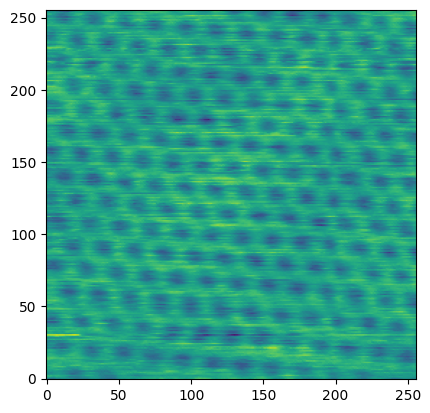

In [45]:
file = "Gr_on_Cu015.sxm"
data = Sxm_Image(file)
image =  data.image()
plt.imshow(image, origin ='lower')

2D-FFT

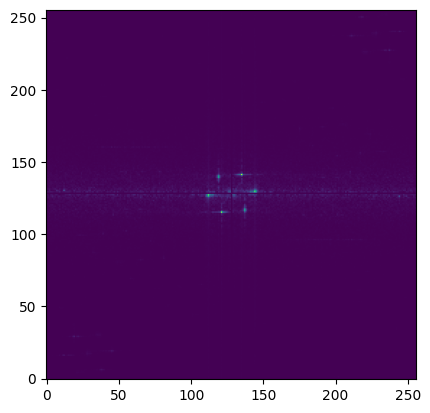

In [48]:
fft = np.asarray(image_to_FFT(image))
plt.imshow(fft, origin='lower')

In [35]:
# Recommended to normalize data in range 0-1
fft_2 = norm_0to1(fft)

#Define frame_size (in nm)
frame = 3

#create data object
fft_data = Fft_Peaks(fft_2, frame)

#Pixels
print(fft_data.pixels)

# get fft space coords
x_fft_array = fft_data.x_fft_array
y_fft_array = fft_data.y_fft_array

#meshgrid
x_f = oneD_to_2D(x_fft_array)
y_f = oneD_to_2D(y_fft_array)

256


Plot data with peaks

In [41]:
#exclude center coordinates
exclude_center = [3,3]

#Get peaks

peak_indices, peak_heights, six_peaks_lattice, height_avg, abs_avg_height = fft_data.hexagon_peak_find(quadrant = exclude_center)

[-2.175163398692809, -4.18300653594771]
[2.5098039215686248, 4.517647058823526]
[-5.186928104575164, -0.5019607843137237]
[5.521568627450979, 0.8366013071895395]
[3.1790849673202626, -5.521568627450979]
[-2.8444444444444468, 5.856209150326795]


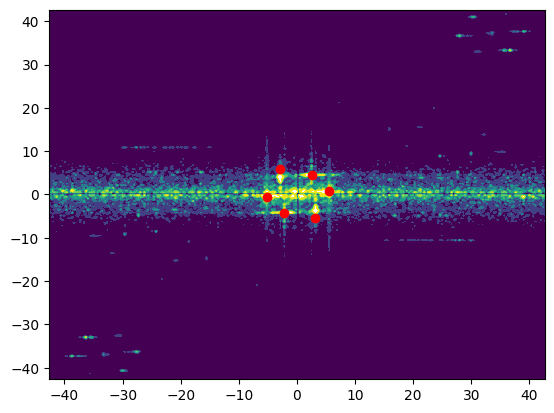

In [42]:
x_peaks  = x_fft_array[peak_indices]
y_peaks = y_fft_array[peak_indices]
for i in range(len(x_peaks)):
    print([x_peaks[i], y_peaks[i]])


fig = plt.contourf(x_f, y_f, fft_2, norm = 'log', levels = np.linspace(0, 0.1, 10))
plt.plot(x_peaks, y_peaks, 'ro')